In [1]:
#This code is to play with output of ellipse fitter and to help set limits for ellipse pruning
import cv2
import csv
import matplotlib.pyplot as plt
import numpy as np
import os


In [61]:
def label_transform(cab_seed, pic_seed, pic_internal, half_module_end):
    #assuming it is labelled normally around the boundary i think this is fine, maximum is 7650
    total_change_x = 0
    total_change_y = 0
    smod_change_x = pic_seed[0] - float(pic_internal[0])
    smod_change_y = pic_seed[1] - float(pic_internal[1])
    intersmod_change_x = pic_seed[2] - float(pic_internal[2])
    intersmod_change_y = pic_seed[3] - float(pic_internal[3])
    
    total_change_x = 4*smod_change_x + intersmod_change_x
    total_change_y = 3*smod_change_y + intersmod_change_y

    if float(pic_internal[0]) >= half_module_end :
        total_change_x += 2
    cab_num = cab_seed + 51*total_change_x + total_change_y
    if cab_num < 0 :
        cab_num = 7650 + (cab_seed + 51*total_change_x + total_change_y) 
    return(cab_num)

['762_pred_substacks_far_unet.19.txt', '757_pred_substacks_far_unet.19.txt', '768_pred_substacks_far_unet.19.txt', '800_pred_substacks_far_unet.19.txt', '756_pred_substacks_far_unet.19.txt', '796_pred_substacks_far_unet.19.txt', '903_pred_substacks_far_unet.19.txt', '773_pred_substacks_far_unet.19.txt', '770_pred_substacks_far_unet.19.txt', '766_pred_substacks_far_unet.19.txt', '769_pred_substacks_far_unet.19.txt', '779_pred_substacks_far_unet.19.txt', '760_pred_substacks_far_unet.19.txt', '793_pred_substacks_far_unet.19.txt', '772_pred_substacks_far_unet.19.txt', '904_pred_substacks_far_unet.19.txt', '777_pred_substacks_far_unet.19.txt', '765_pred_substacks_far_unet.19.txt', '776_pred_substacks_far_unet.19.txt', '759_pred_substacks_far_unet.19.txt', '771_pred_substacks_far_unet.19.txt', '801_pred_substacks_far_unet.19.txt', '784_pred_substacks_far_unet.19.txt', '799_pred_substacks_far_unet.19.txt', '797_pred_substacks_far_unet.19.txt', '791_pred_substacks_far_unet.19.txt', '778_pred_s

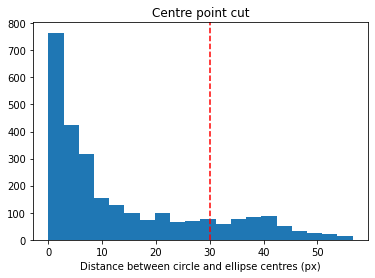

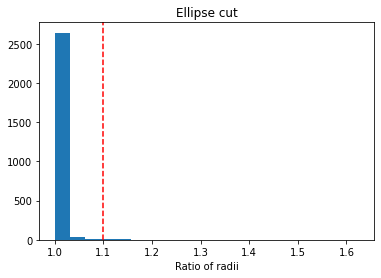

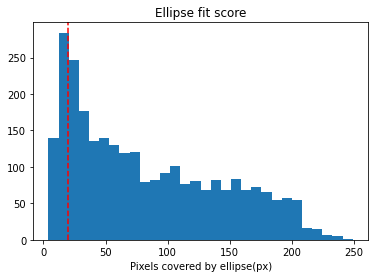

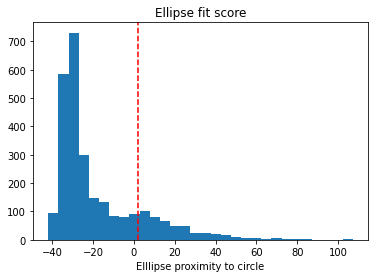

In [62]:

#pmt: 00,  circle, ellipse, label
#bolt: no. centroid, label

#Seed: 1 pmt and real label to do the rest of the ring 
#B2 uk injector :[1490.73, 768.14, 666.65], between super modules at [0, 0], [0,1] koread is between [0,1], [0,2]
# /usr/local/sklib_gcc4.8.5/skofl_20a/const/connection.super.sk-5.dat
#seed_pmt_cab = 595
#seed_pmt_pic = [15, -1, 0, 2] #below and to right of korean injector in image 776
seed_pmt_cab = 594
seed_pmt_pic = [15, 0, 0, 0]
half_module_end = float(31)
#do pmt labelling by super module: work out [0, 0] for seed smodule then transfer to each super module


#variable storage
geom_info = {'pmts':{'circles':[], 'ellipses':[]}, 'bolts':[]}
#pruning parameters
circ_ell_diff = []
ecc = []
score = []
ell_circ_overlap = []

#pruning limits
circ_ell_diff_limit = float(30)
ecc_limit = float(1.1)
score_limit = float(20)
overlap_limit = float(2)


idir = '/home/dm3315/Documents/SK/PMT_learning/images/datasets/substacks_far/\
output/ring_avg_all/feature_info/supervised/coords/'
odir = '/home/dm3315/Documents/SK/PMT_learning/images/datasets/substacks_far/output/ring_avg_all/feature_info/supervised/final_points/'

f = []
for (dirpath, dirnames, filenames) in os.walk(f'{idir}'):
    f.extend(filenames)
    break
    
#Check half module images as theyre usually wrong somewhere
#f = ['792_pred_substacks_far_unet.19.txt', '793_pred_substacks_far_unet.19.txt', '794_pred_substacks_far_unet.19.txt']
print(f)
all_label_file = open(f'{odir}final_labels_all.txt', 'w')
all_label_file.close()
all_label_file = open(f'{odir}final_labels_all.txt', 'a')

prev_pmt_line_label = '0'

for filename in f:
    img_num = filename[:3]
    img_label_file = open(f'{odir}{img_num}_labels_all.txt', 'w')
    img_label_file.close()
    img_label_list = []
    with open (f'{idir}{filename}', 'r') as info :
        #load image and copy to see effect
        img_label_file = open(f'{odir}{img_num}_labels_all.txt', 'a')
        print(img_num)
        img_after = cv2.imread(f'/home/dm3315/Documents/SK/PMT_learning/images/Raw/neutsrv2.triumf.ca/neutshare/superk/TOW-Feb2020/Processed/BarrelSurveyRings_TB3/BarrelSurveyRings_median/ring_avg_all/{img_num}.jpg')
        #img_before = img_before.copy()
        new_PMT = False
      #  if img_num == '780' :
      #      overlap_limit = -5
            
        for row in csv.reader(info, delimiter=':') :
            #print(row)
            feature_label = row[0]
            if len(feature_label) <2 :
                feature_label = f'0{row[0]}'

            
            if row[0] == '00':
                new_PMT = True
                pmt_label = row[9]
                pmt_label_list = pmt_label[1:-1].split(',')
                pmt_label = label_transform(seed_pmt_cab, seed_pmt_pic, pmt_label_list, half_module_end)
                circ_1 = int(row[1])
                circ_2 = int(row[2])
                circ_r = int(row[3])
                ell_1 = int(row[4])
                ell_2 = int(row[5])
                ell_r1 = int(np.floor(float(row[6])))    #inputs are wonky here)
                ell_r2 = int(np.floor(float(row[7])))
                ell_ang = int(row[8])
                ell_score = int(row[10])
                geom_info['pmts']['circles'].append([circ_1, circ_2, circ_r])
                geom_info['pmts']['ellipses'].append([ell_1, ell_2, ell_r1, ell_r2, ell_ang])
            
                #draw image before cuts
                #cv2.circle(img_before, (int(row[1]), int(row[2])), int(row[3]), (155, 155, 155), 2)
                #cv2.ellipse(img_before, (ell_1, ell_2), (ell_r1, ell_r2), ell_ang, 0, 360, (255, 255, 255), 2)

                #make array of cut variables
                score.append(ell_score/255)
                
                diff = ((circ_1 - ell_1)**2 + (circ_2 - ell_2)**2)**0.5
                circ_ell_diff.append(diff)

                if ell_r1 > ell_r2 :
                    ell_ecc = ell_r1/ell_r2
                    ell_major = ell_r1
                else :
                    ell_ecc = ell_r2/ell_r1
                    ell_major = ell_r2
                ecc.append(ell_ecc)
                ell_circ_overlap.append(diff + ell_major - circ_r)
                #assume ellipse is mostly circular, see if it is contained in the circle
                
                #reject based on vars
                #purple:difference between centres
                #green:eccentricity
                #red:score

                if ell_score < score_limit*255 :
                    cv2.circle(img_after, (circ_1, circ_2), circ_r, (0, 0, 155), 2)
                    cv2.ellipse(img_after, (ell_1, ell_2), (ell_r1, ell_r2), ell_ang, 0, 360, (0, 0, 255), 2)
                
                elif diff + ell_major > circ_r - overlap_limit :
                    cv2.circle(img_after, (circ_1, circ_2), circ_r, (0, 155, 0), 2)
                    cv2.ellipse(img_after, (ell_1, ell_2), (ell_r1, ell_r2), ell_ang, 0, 360, (0, 255, 0), 2)  
                    
                elif diff > circ_ell_diff_limit :
                    cv2.circle(img_after, (circ_1, circ_2), circ_r, (155, 0, 155), 2)
                    cv2.ellipse(img_after, (ell_1, ell_2), (ell_r1, ell_r2), ell_ang, 0, 360, (255, 0, 255), 2)
                    
                elif ell_ecc > ecc_limit :
                    cv2.circle(img_after, (circ_1, circ_2), circ_r, (155, 0, 0), 2)
                    cv2.ellipse(img_after, (ell_1, ell_2), (ell_r1, ell_r2), ell_ang, 0, 360, (255, 0, 0), 2)
                
                #write to file here
                else:
                    cv2.circle(img_after, (circ_1, circ_2), circ_r, (155, 155, 155), 2)
                    cv2.ellipse(img_after, (ell_1, ell_2), (ell_r1, ell_r2), ell_ang, 0, 360, (255, 255, 255), 2)
                    img_label_file.write(f'{img_num}\t{str(int(pmt_label)).zfill(5)}-{feature_label}\t{ell_1}\t{ell_2}\tDM\n')
                    all_label_file.write(f'{img_num}\t{str(int(pmt_label)).zfill(5)}-{feature_label}\t{ell_1}\t{ell_2}\tDM\n')
                cv2.putText(img_after, f'Score < {score_limit}px', (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)
                cv2.putText(img_after, f'Ellipse in circle > {overlap_limit}px', (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 2)
                cv2.putText(img_after, f'Centre diff > {circ_ell_diff_limit}px', (100, 300), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,255), 2)
                cv2.putText(img_after, f'Ratio of radii < {ecc_limit}px', (100, 400), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 2)
                
                #transform label to cable numbers

                
                cv2.putText(img_after, f'{pmt_label}', ( ell_1-100, ell_2), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
                if float(pmt_label_list[0]) not in  img_label_list :
                    if len(img_label_list) == 0 :
                        img_label_list.append(float(pmt_label_list[0]))
                    elif float(pmt_label_list[0]) > np.min(img_label_list) :
                        img_label_list.append(float(pmt_label_list[0]))
                        cv2.line(img_after, (circ_1-200, 0), ( circ_1-200, 2750), (255, 255, 255), thickness = 3)
                        cv2.putText(img_after, f'{pmt_label_list[0]} ', ( circ_1-150, 1000), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255), 2)
            else :
                pmt_label = row[3]
                geom_info['bolts'].append([row[1], row[2]])



    #save images

    #cv2.imwrite( f'/home/dm3315/Documents/SK/PMT_learning/images/datasets/substacks_far/output/ring_avg_all/feature_info/coords/cuts/{img_num}_before.png', img_before)
    cv2.imwrite( f'/home/dm3315/Documents/SK/PMT_learning/images/datasets/substacks_far/output/ring_avg_all/feature_info/supervised/coords/cuts/{img_num}_after.png', img_after)
    img_label_file.close()
all_label_file.close()
    
#plots of variables
#center differences
fig1, axs1 = plt.subplots(1, 1)
axs1.hist(circ_ell_diff, bins=20)
axs1.set_title('Centre point cut')
axs1.set_xlabel('Distance between circle and ellipse centres (px)')
axs1.axvline(x = circ_ell_diff_limit, color = 'r', linestyle = '--') 
     
#radii ratio
fig2, axs2 = plt.subplots(1, 1)
axs2.hist(ecc, bins=20)
axs2.set_title('Ellipse cut')
axs2.set_xlabel('Ratio of radii')
axs2.axvline(x = ecc_limit, color = 'r', linestyle = '--') 

#score
fig3, axs3 = plt.subplots(1, 1)
axs3.hist(score, bins=30)
axs3.set_title('Ellipse fit score')
axs3.set_xlabel('Pixels covered by ellipse(px)')
axs3.axvline(x =score_limit, color = 'r', linestyle = '--') 

#overlap
fig4, axs4 = plt.subplots(1, 1)
axs4.hist(ell_circ_overlap, bins=30)
axs4.set_title('Ellipse fit score')
axs4.set_xlabel('Elllipse proximity to circle')
axs4.axvline(x =overlap_limit, color = 'r', linestyle = '--') 

In [57]:
test = '[1, 2, 3, 4]'
upd = test[1:-1].split(',')
print(int(upd[1]))

2


In [45]:
#test pmt label transform
seed_pmt_cab = 594
seed_pmt_pic = [15, 0, 0, 0]

pmt_label_test = '[14, 1, 3, 2]' # should transform to +51 in x, -5 in y so 594 ->640
pmt_label_list = pmt_label_test[1:-1].split(',')
print(pmt_label_list)
pmt_cable_num = label_transform(seed_pmt_cab, seed_pmt_pic, pmt_label_list)
print(pmt_cable_num)

['14', ' 1', ' 3', ' 2']


TypeError: label_transform() missing 1 required positional argument: 'half_module_end'

In [ ]:
#try to find pmt cable numbers
infile = '/home/dm3315/Documents/SK/PMT_learning/connection.super.sk-5.dat'

xmin = 1450
xmax = 1550
ymin = 700
ymax = 850
zmin = 600
zmax = 750
store = []
with open (f'{infile}', 'r') as info :

    for row in csv.reader(info, delimiter=' ') :
        if row[0] != '#' :
            row=list(filter(lambda x:x !='',row))
            if int(row[0]) < 8339:
                #print(row)
     #           if (xmin < int(row[16]) < xmax) :
     #               if (ymin < int(row[17]) < ymax) :
     #                   if (zmin < int(row[18]) < zmax ):
     #                       print(row)
                if abs(int(row[18])) < 1810 :
                   # print(row[18])
                    store.append(int(row[0]))

print(np.sort(store))

